<a href="https://colab.research.google.com/github/VMiokova/Project/blob/main/hypothesis_prioritization_AB_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Приоритизация гипотез и A/B-тестирование в интернет-магазине<h1/>

### Загрузка данных и подготовка их к анализу

In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from pandas.plotting import register_matplotlib_converters
from google.colab import drive

In [ ]:
drive.mount('/gdrive')

hypothesis_id = '1Vhx9a4hGm8BAF5qwcQ09JIcHxbmfZteT'
orders_id = '1xW9QhUJNebJ0rujk5Q17rKc5bG1UD7nT'
visitors_id = '1Zlhv9FIlZiBXMW9ZK7nhIWxK9JbcVtXR'

link_hypothesis = 'https://drive.google.com/uc?id=' + hypothesis_id
link_orders = 'https://drive.google.com/uc?id=' + orders_id
link_visitors = 'https://drive.google.com/uc?id=' + visitors_id

hypothesis = pd.read_csv(link_hypothesis, error_bad_lines=False)
orders = pd.read_csv(link_orders, error_bad_lines=False)
visitors = pd.read_csv(link_visitors, error_bad_lines=False)

Mounted at /gdrive


<ipython-input-2-4c07d7127d5d>:11: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  hypothesis = pd.read_csv(link_hypothesis, error_bad_lines=False)
<ipython-input-2-4c07d7127d5d>:12: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  orders = pd.read_csv(link_orders, error_bad_lines=False)
<ipython-input-2-4c07d7127d5d>:13: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  visitors = pd.read_csv(link_visitors, error_bad_lines=False)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.options.display.max_colwidth = 170

display(hypothesis.head(3))
display(orders.head(3))
display(visitors.head(3))

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


In [ ]:
for df in [hypothesis]:
    print(df.isnull().sum())
    print(df.duplicated().sum())

for df in [orders]:
    print(df.isnull().sum())
    print(df.duplicated().sum())

for df in [visitors]:
    print(df.isnull().sum())
    print(df.duplicated().sum())

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64
0
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
0
date        0
group       0
visitors    0
dtype: int64
0


In [ ]:
hypothesis.columns = [x.lower().replace(' ', '_') for x in hypothesis.columns.values]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
visitors.columns = [x.lower().replace(' ', '_') for x in visitors.columns.values]

In [ ]:
dataframes = [hypothesis, orders, visitors]

for df in dataframes:
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')


print(hypothesis.dtypes)
print(orders.dtypes)
print(visitors.dtypes)

hypothesis    object
reach          int32
impact         int32
confidence     int32
efforts        int32
dtype: object
transactionid     int32
visitorid         int32
date             object
revenue           int32
group            object
dtype: object
date        object
group       object
visitors     int32
dtype: object


In [ ]:
num_groups = orders['group'].nunique()
print(f'Количество групп в АВ-тесте: {num_groups}')

Количество групп в АВ-тесте: 2


In [ ]:
start_date = orders['date'].min()
end_date = orders['date'].max()
print(f'Дата начала теста: {start_date}')
print(f'Дата окончания теста: {end_date}')

Дата начала теста: 2019-08-01
Дата окончания теста: 2019-08-31


In [ ]:
num_users_per_group = orders.groupby('group')['visitorid'].nunique()
print(f'Количество пользователей в каждой группе:\n{num_users_per_group}')

Количество пользователей в каждой группе:
group
A    503
B    586
Name: visitorid, dtype: int64


In [ ]:
users_group_A = set(orders[orders['group'] == 'A']['visitorid'])
users_group_B = set(orders[orders['group'] == 'B']['visitorid'])

users_both_groups = users_group_A.intersection(users_group_B)
percentage = len(users_both_groups) / orders['visitorid'].nunique() * 100

print(f'Процент пользователей, попавших в обе группы: {percentage}%')

Процент пользователей, попавших в обе группы: 5.625606207565471%


Есть небольшое пересечение групп. 5.6% пользователей попали в обе группы, это приемлемо в зависимости от контекста эксперимента.

##  Приоритизация гипотез.

In [ ]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2)
sorted_hypotheses = hypothesis.sort_values(by='ICE', ascending=False)
sorted_hypotheses['ICE'] = sorted_hypotheses['ICE'].astype(float).map('{:.2f}'.format)

print(sorted_hypotheses[['hypothesis', 'ICE']])

                                                                                                     hypothesis  \
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользоват

Восьмая гипотеза (Запустить акцию, дающую скидку на товар в день рождения) — самая перспективная по ICE.

Затем идут гипотезы:
- 0 (Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей),
- 7 (Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок),
- 6 (Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию).  

In [ ]:
hypothesis ['RICE']= (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
sorted_data_r = hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)
print(sorted_data_r)

                                                                                                     hypothesis  \
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позвол

И снова наиболее перспективные гипотезы:
- 7 (Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок),
- 6 (Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию),
- 0 (Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей).

Гипотеза 2 (Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа)- на втором месте.

Однако восьмая гипотеза (Запустить акцию, дающую скидку на товар в день рождения) на месте уже под номером 5.

При переходе от ICE к RICE приоритизация гипотез изменилась. Это произошло из-за того, что RICE включает дополнительный компонент - Reach (охват). Он оценивает, сколько пользователей будут затронуты изменениями, которые планируют внести.

Таким образом, при переходе от ICE к RICE, гипотезы с большим охватом получили более высокий приоритет. Это поможет учесть не только важность и уверенность в гипотезе, но и то, сколько пользователей она затронет.

## Анализ A/B-теста

Приступим к изучению данных из файлов с заказами и посетителями.

In [ ]:
register_matplotlib_converters()

orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

datesGroups = orders[['date','group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionid': 'nunique',
            'visitorid': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])


cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


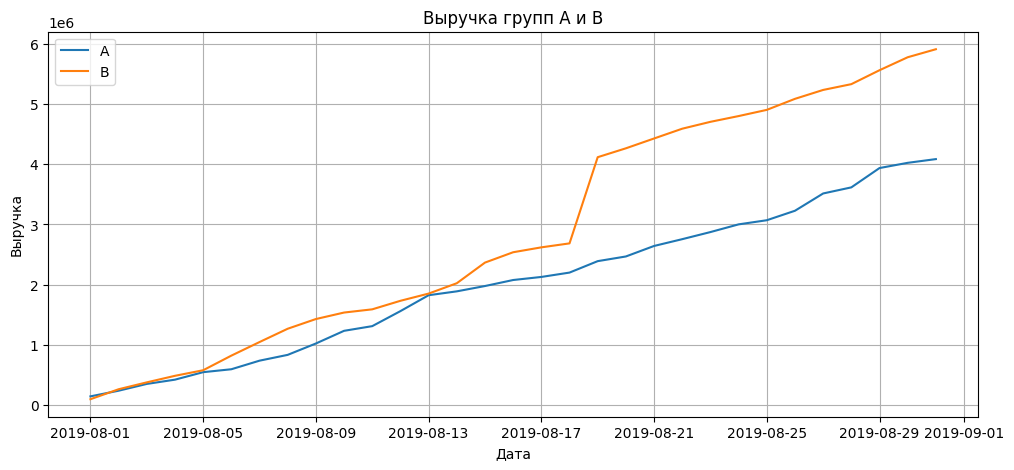

In [ ]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']]

cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']]

plt.figure(figsize=(12, 5))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('Выручка групп A и B')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid(True)
plt.legend()
plt.show()

В середине теста сегмент B вырвался вперёд и продолжал лидировать весь остаток теста. Похоже, что аномально большие заказы всё-таки влияют на результаты.

Построим график кумулятивного среднего чека по группам.

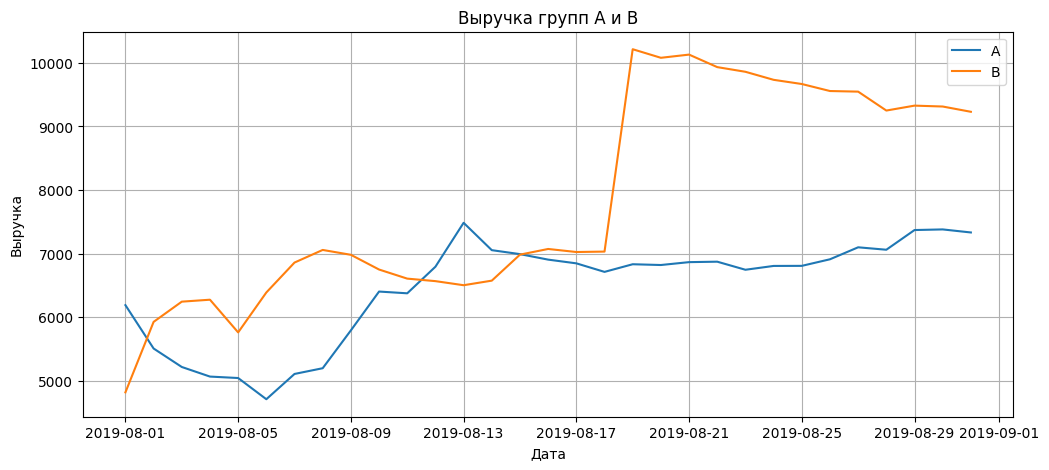

In [ ]:
plt.figure(figsize=(12, 5))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('Выручка групп A и B')
plt.xlabel('Дата')
plt.ylabel('Выручка')

plt.grid(True)

plt.legend()
plt.show()

Кумулятивное значение среднего чека по сегментам продолжает колебаться. Возможно, в группу B в второй половине теста попали крупные заказы (резкий всплеск на графике). Принимать решение по этой метрике рано. Требуется дополнительный анализ выбросов, которые искажают результаты.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

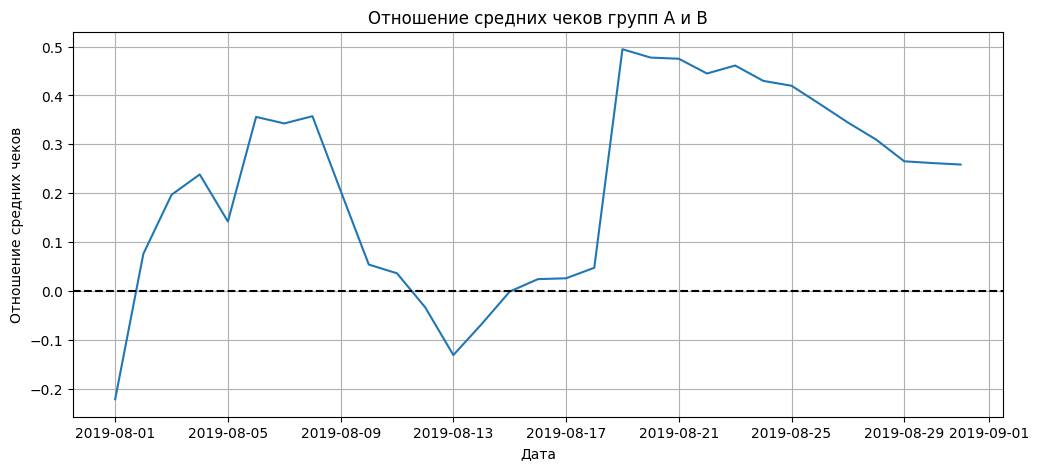

In [ ]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12, 5))

plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.title('Отношение средних чеков групп A и B')
plt.xlabel('Дата')
plt.ylabel('Отношение средних чеков')

plt.grid(True)
plt.show()

Результаты теста значительно и резко менялись в несколько дат. В нескольких точках график различия между сегментами резко «скачет». Видимо, именно тогда были совершены аномальные заказы.

Построим график кумулятивного среднего количества заказов на посетителя по группам.

Зададим масштаб осей методом plt.axis(). Передадим ему минимальное и максимальное значения оси x; минимальное и максимальное значения оси y — ["2019-08-01", '2019-09-01', 0, 0.05]:

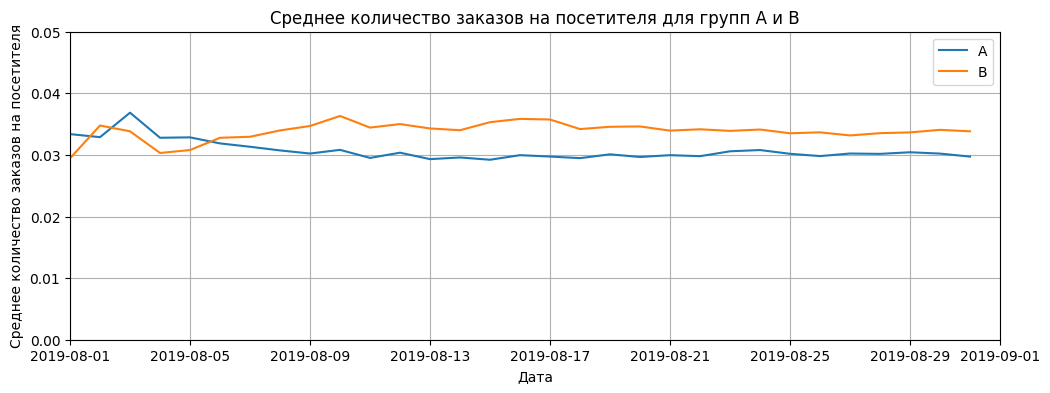

In [ ]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(12, 4))

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.title('Среднее количество заказов на посетителя для групп A и B')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов на посетителя')

plt.grid(True)
plt.legend()

plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05])
plt.show()

В начале теста сегмент A имел большее кумулятивное среднее количество заказов. Группы колебались около одного значения, но затем у группы В среднее количество заказов вырвалось вперёд и зафиксировалось, а у группы А — просело, но тоже зафиксировалось. Абсолютное значение колебания в начале и в конце теста не слишком большое: от 3% до 4%.

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

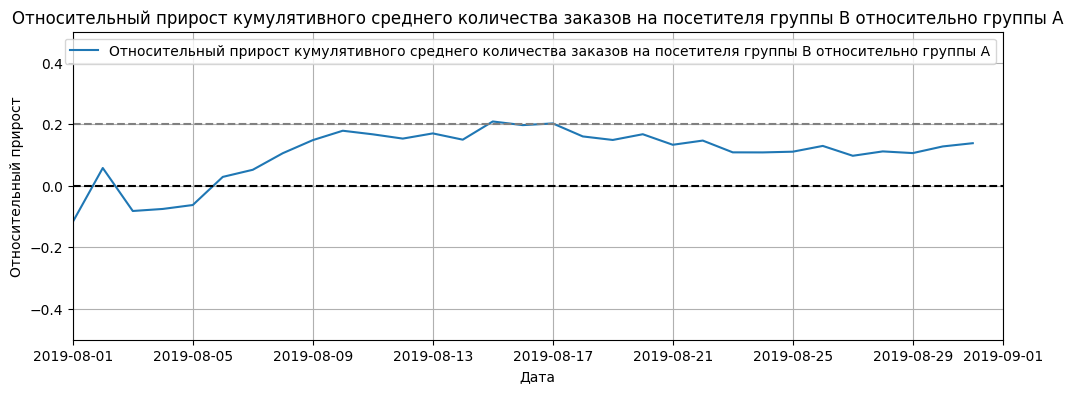

In [ ]:
cumulativeData['conversion'] = (
    cumulativeData['orders'] / cumulativeData['visitors'])

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12, 4))

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A")

plt.title('Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A')
plt.xlabel('Дата')
plt.ylabel('Относительный прирост')

plt.grid(True)
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')

plt.axis(["2019-08-01", '2019-09-01', -0.5, 0.5])
plt.show()

Группа B лидирует по метрике: становится лучше и лучше, и зафиксировалась около прироста в 20% относительно группы A.

Построение точечного графика количества заказов по пользователям.

In [ ]:
ordersByUsers = (
    orders.groupby('visitorid', as_index=False)
    .agg({'transactionid': 'nunique'}))

ordersByUsers.columns = ['visitorid', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

       visitorid  orders
508    -38926894      11
76   -1836965644      11
54   -1916032177       9
1003  2038680547       8
571    237748145       5
229  -1232533704       5
382   -577274894       5
815   1230306981       5
402   -491698131       5
560    199603092       5


Получили число заказов по пользователям. Есть пользователи, которые совершали 9, 8 и 11 заказов. Значительно больше, чем обычный пользователь за неделю.

Строим **диаграмму методом scatter()**.

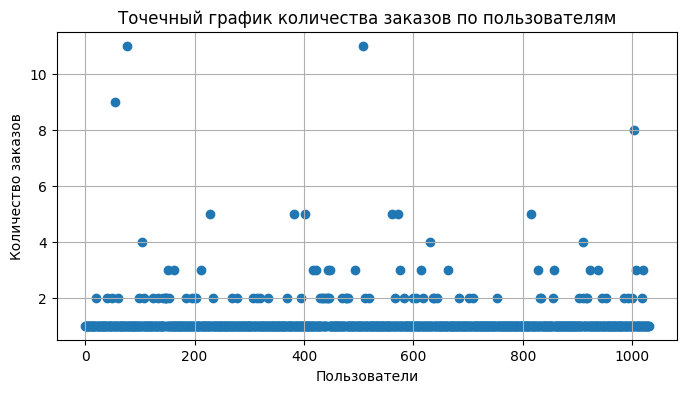

In [ ]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(8, 4))
plt.scatter(x_values, ordersByUsers['orders'])

plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')

plt.grid(True)
plt.show()

Можно сделать вывод: много пользователей с 2-3 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет.

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Определим границу для определения аномальных пользователей.

In [ ]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Выводы подтверждаются, что 5 % пользователей совершают не более двух заказов, и 1% совершает не более четырех заказов.
Границу между “нормальными” и “аномальными” пользователями установим на уровне четырех заказов.

Построим точечный график стоимостей заказов.

      transactionid   visitorid       date  revenue group
425       590470918  1920142716 2019-08-19  1294500     B
1196     -358190231  2108080724 2019-08-15   202740     B
858       192721366  1316129916 2019-08-27    93940     A
1136      666610489  1307669133 2019-08-13    92550     A
744      -626659113   888512513 2019-08-27    86620     B
682      1216533772   -28031466 2019-08-29    78990     B
662      1811671147   -28031466 2019-08-29    78990     A
743      -691390987  -161932463 2019-08-09    67990     A
1103     1348774318  1164614297 2019-08-12    66350     A
1099      316924019   148427295 2019-08-12    65710     A


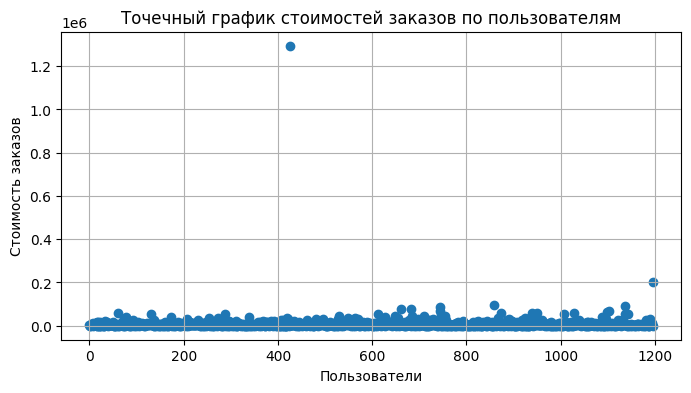

In [ ]:
print(orders.sort_values(by='revenue', ascending=False).head(10))

x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(8, 4))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов')

plt.grid(True)
plt.show()

Заказ на 1 миллион в интернет-магазине может быть аномальным. Есть выбросы в районе 200000  рублей и в районе 1294500 рублей, так как они значительно превышают стоимость большинства заказов. Это может быть связано с покупкой дорогих товаров или большим количеством товаров в одном заказе.

Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [ ]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более, чем у 5% заказов чек дороже 28 000 рублей. И не больше, чем у 1% заказов — дороже 58 233 рублей. Установим границу для определения аномальных заказов на уровне 58 000 рублей. Заказы, превышающие эту сумму, будут считаться аномальными и будут исключены из дальнейших анализов.

Вывод: Большинство клиентов тратят относительно небольшие суммы, и очень дорогие заказы являются редкостью. Заказ на 1 миллион рублей действительно аномальный, так как он значительно превышает даже 99-й перцентиль стоимости заказов.

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть.

In [ ]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(3))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               380996               507   

   visitorsPerDateB  visitorsCummulativeA  visitorsCummulativeB  
0               713                   719                   713  
1               581                  1338                  1294  
2               509            

In [ ]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorid', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorid', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


print('P-value: {0:.5f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print('Относительный прирост среднего группы B к конверсии группы A: {0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))
print('Относительное изменение конверсии группы B к группе A: {0:.3f}'.format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))

P-value: 0.01679
Относительный прирост среднего группы B к конверсии группы A: 0.138
Относительное изменение конверсии группы B к группе A: 0.138


P-value меньше 0.05, потому нулевую гипотезу отвергаем. Анализ «сырых данных» сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы B к конверсии группы A равен 13.8%.
Осталось сравнить средние чеки по «сырым данным», а затем обе метрики ещё раз после удаления выбросов.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

In [ ]:
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие среднего чека между сегментами: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value: 0.729
Относительное различие среднего чека между сегментами: 0.259


P-value значительно больше 0.05. Причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Относительное различие среднего чека между сегментами 25.9%

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

In [ ]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['visitorid'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['visitorid'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 58000]['visitorid']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

28    -1916032177
35    -1836965644
940    -291338710
743    -161932463
256     -38926894
Name: visitorid, dtype: int32
15


Отбросим 15 аномальных пользователей.

Посчитаем статистическую значимость различия среднего количества заказов после удаления аномальных пользователей.

In [ ]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('P-value: {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительное изменение среднего значения выборки B по отношению к среднему значению выборки A: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

P-value: 0.01438
Относительное изменение среднего значения выборки B по отношению к среднему значению выборки A: 0.153


Как и в случае с сырыми данными, статистическая значимость достигнута. Сегмент B лучше сегмента A.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [ ]:
print(
    'P-value: {0:.5f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительное изменение среднего чека между группами A и B после исключения аномальных пользователей: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value: 0.85091
Относительное изменение среднего чека между группами A и B после исключения аномальных пользователей: -0.006


P-value увеличился, но и разница между сегментами сократилась с 25% до 6%.
Общие выводы по результатам теста не изменились.

###  Решение по результатам теста.

Варианты решений:

- Остановить тест, зафиксировать победу одной из групп.
- Остановить тест, зафиксировать отсутствие различий между группами.
- Продолжить тест.

Анализ данных показывает, что сегмент B в целом превосходит сегмент A, особенно в отношении конверсии.

p-value для среднего чека значительно больше 0.05, что говорит о том, что нет статистически значимых различий между сегментами по этой метрике. С другой стороны, p-value для конверсии меньше 0.05, что указывает на статистически значимые различия между сегментами.

Учитывая эти факты, я бы рекомендовала следующее:

-**Продолжить тест.**  Мы хотим получить более четкую картину относительно среднего чека. Конверсия не является ключевым фактором, нам важно быть полностью уверенными в среднем чеке, тогда продолжение теста может быть лучшим решением. Однако это может потребовать больше времени и ресурсов.